# Google colab setup

In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
import os
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/computerVision/Cw' 
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['training_SIFT_models.ipynb', 'CW_Dataset.zip', '.ipynb_checkpoints', 'HOG_SVM.joblib', 'HOG_MLP.joblib', 'HOG_RFC.joblib', 'training_HOG_models.ipynb', 'test', 'EmotionRecognition.ipynb', 'Kmeans.joblib', 'Untitled0.ipynb', 'ZIFT_SVM', 'ZSIFT_SVM']


In [52]:
!pip install opencv-python==4.4.0.46

# Introduction
this file contains all the classification models trainied with the SIFT feature descriptors. 
the process involves :



1.   unzipping the files
1.   loading the dataset
1.   extracting SIFT feature descriptors of the dataset
1.   clustering
2.   histogram of codewords
2.   training the classifier
3.   evaluating the classifier
4.   Hyper-parameter tuning
5.   Evaluation after tuning
6.   save the best classifier model










# Loading and preparing the Dataset
this involves loading the train set and test sets and extracts SIFT features and convert them to histrogram od codewords

## unzipping the dataset on colab
zipped dataset is unziped directly on the colab server for faster data accessing 

In [53]:
#adapted from lab 7
# Identify path to zipped dataset
zip_path = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset.zip')
# Copy it to Colab
!cp '{zip_path}' .

# Unzip it
!yes|unzip -q CW_Dataset.zip

# Delete zipped version from Colab (not from Drive)
!rm CW_Dataset.zip

replace test/test_0288_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_0828_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_1505_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_0317_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_1055_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_0647_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_2986_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_1923_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_0591_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_2326_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_1383_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_2676_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_3064_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_2819_aligned.jpg? [y

In [54]:
#import messesary libraries
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import shuffle
from skimage import img_as_ubyte, io, color
from collections import Counter
from sklearn.cluster import MiniBatchKMeans
from sklearn import svm, metrics
from joblib import dump

%matplotlib inline

## Loading the train dataset

In [55]:
# function to load and return images data and labels
def import_dataset(images_path, label_path):
  images_list = []  # empty images list
  labels_list = [] # empty label list
  #read all the image files
  for file in sorted(os.listdir(images_path)):
    if file.endswith('.jpg'):
      image = io.imread(os.path.join(images_path,file))     #read the image
      images_list.append(image)    #add it to the images list

  


  #get the labels for each image from the txt file  

  data = np.genfromtxt(label_path)    #txt file to np
  labels = data[:,1]
  labels = labels.astype(int)    #convert label to int
  labels_list = labels.tolist()   #add to the label list

  return images_list, labels_list



In [56]:
#import training images and corresponding labels
train_images, train_labels = import_dataset('train','labels/list_label_train.txt')


In [57]:
print(len(train_images))

12271


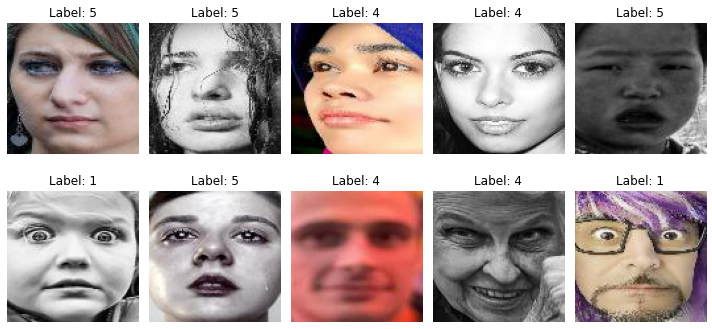

In [58]:
#display 10 images of the train set
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5), sharex=True, sharey=True)
ax = axes.ravel()

for i in range(10):
    ax[i].imshow(train_images[i], cmap='gray')
    ax[i].set_title(f'Label: {train_labels[i]}')
    ax[i].set_axis_off()
fig.tight_layout()
plt.show()

In [59]:
#show number of different label classes
unique, counts = np.unique(train_labels, return_counts=True)

print(np.asarray((unique, counts)))

[[   1    2    3    4    5    6    7]
 [1290  281  717 4772 1982  705 2524]]


### SIFT feature descriptors extraction

sift.detectandcompute() function was used to extract the descriptors of the dataset

In [60]:
#adapted from lab 7
# a funtion to extract the SHIFT feature descriptors of the images with corresponding labels

def extract_SIFT_featureDes(images, labels):
  sift = cv2.SIFT_create()
  SIFT_descriptors = []
  SIFT_keypoints= []
  label_list =[]

  for i in range(len(images)):
    img= img_as_ubyte(color.rgb2gray(images[i]))
    kp, des = sift.detectAndCompute(img,None)
    if des is not None:
      SIFT_descriptors.append(des)
      SIFT_keypoints.append(kp)
      label_list.append(labels[i])


  return SIFT_descriptors, SIFT_keypoints, label_list


In [61]:
#extracting the training SIFT descriptors of the train dataset
train_SIFT_descriptors, train_SIFT_kp, train_SIFT_labels = extract_SIFT_featureDes(train_images,train_labels)

In [62]:
  print(np.array(train_SIFT_descriptors).shape)
  print(len(train_SIFT_labels))

(12264,)
12264


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


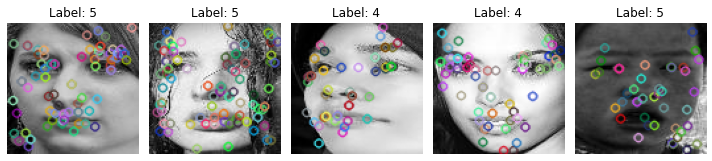

In [63]:
## plots 5 images from traing set with SIFT decriptors keypoints
fig, ax = plt.subplots(1, 5, figsize=(10, 8), sharey=True)
for i in range(5):
  if train_SIFT_descriptors is not None:
    img = img_as_ubyte(color.rgb2gray(train_images[i]))
    img_with_SIFT = cv2.drawKeypoints(img,train_SIFT_kp[i] , img) #draw  key point on the image 
    ax[i].imshow(img_with_SIFT)
    ax[i].set_title(f'Label: {train_labels[i]}')
    ax[i].set_axis_off()
fig.tight_layout()
plt.show()

### descriptor clustering

In [64]:
###clusterning the descriptor with MiniBatchKMeans###

train_des_array = np.vstack(train_SIFT_descriptors)  # convert the descriptors into arrays

#number of codewords/centroids (Classes)
k= len(np.unique(train_SIFT_labels)) *10    #idial k is number of classes * 10

Kmeans = MiniBatchKMeans(n_clusters=k,batch_size=train_des_array.shape[0]//5).fit(train_des_array)



In [65]:
#save kmeans clustering
path = os.path.join('drive', 'My Drive', 'Colab Notebooks/computerVision/Cw/Kmeans.joblib' )
dump(Kmeans, path)

['drive/My Drive/Colab Notebooks/computerVision/Cw/Kmeans.joblib']

### Histogram of Codewords

In [66]:
#adapted from lab 7
# function to convert the desctriptors into histogram of codewords
def create_hist_words (descriptors):
  hist_list=[]
  for des in descriptors:
    hist = np.zeros(k)
    idx= Kmeans.predict(des)
    
    for j in idx:
      hist[j] = hist[j] + (1/len(des))
    hist_list.append(hist)

  return hist_list

In [67]:
#converto descriptors of each training images into histogram of codewords
train_hist_list = create_hist_words(train_SIFT_descriptors)


## Loading and preparing the Test dataset

In [68]:
## lets load the test set and extract SIFT descriptors of each images and create histogram of them
test_images, test_labels = import_dataset('test','labels/list_label_test.txt')
test_SIFT_descriptors, test_SIFT_kp, test_SIFT_labels = extract_SIFT_featureDes(test_images,test_labels)
test_hist_list = create_hist_words(test_SIFT_descriptors)

**Here the SIFT feture descriptors extracted above will be used to train different image classifiers.**

In [69]:


#assigning X_train and y_train
X_train= np.vstack(train_hist_list)
y_train= train_SIFT_labels

# shuffle the dataset to prevent biases,
# by preventing the moddel from learning the order of th etraining 
X_train , y_train = shuffle(X_train, y_train, random_state=42)


In [70]:
#assinging the X_test and y_test
X_test= np.vstack(test_hist_list)
y_test = test_SIFT_labels


# SIFT-SVM

## Training SVM classifier

In [71]:
# training the svm classifier by passing the codeword histograms of the traing images and their labels
from sklearn import svm

#classifier
svm_classifier= svm.SVC(kernel='rbf')
svm_classifier.fit(X_train,y_train)


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

## Evaluating the trained SVM classifier

In [72]:

#predicting the test set
svm_predict = svm_classifier.predict(X_test).tolist()

In [73]:
# printing the classifier report
print(f"""Classification report for classifier {svm_classifier}:
      {metrics.classification_report(y_test, svm_predict)}\n""")

Classification report for classifier SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False):
                    precision    recall  f1-score   support

           1       0.48      0.09      0.15       329
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00       160
           4       0.43      0.86      0.57      1184
           5       0.39      0.04      0.08       478
           6       0.00      0.00      0.00       162
           7       0.37      0.32      0.34       679

    accuracy                           0.42      3066
   macro avg       0.24      0.19      0.16      3066
weighted avg       0.36      0.42      0.33      3066




/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


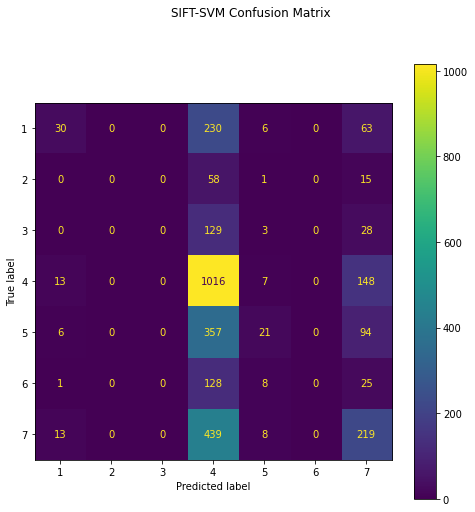

In [74]:
#displays the Confusion matrix of the classifer
fig, ax = plt.subplots(figsize=(8,8))
disp = metrics.plot_confusion_matrix(svm_classifier, X_test, y_test, values_format = 'd', ax=ax)
disp.figure_.suptitle("SIFT-SVM Confusion Matrix")
plt.show()

## Improving the SVM classifier

Hyper Parametering tuning with Grid search will be used to improve the classifer by finding the best optimal parameters

### Hyper-Parameter tuning

In [75]:
# SVM Hyper parameter tuning using GridSearch to find the best optimal Hyper-parameter
#adapted from https://www.geeksforgeeks.org/svm-hyperparameter-tuning-using-gridsearchcv-ml/

from sklearn.model_selection import GridSearchCV

# defining parameter range
svm_param_grid = {'C': [0.1, 1, 10], 
              'gamma': [1, 0.5, 0.1],
              'kernel': ['rbf','poly']} 
#classifier  
svm_grid_classifier = GridSearchCV(svm.SVC(), svm_param_grid, refit = True,cv = 5, verbose = 4)

In [76]:
# traning the classifier with grid parameters
svm_grid_classifier.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.389, total=  21.2s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.2s remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.389, total=  21.2s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   42.4s remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.389, total=  21.3s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.1min remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.389, total=  21.3s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.389, total=  21.4s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ......... C=0.1, gamma=1, kernel=poly, score=0.389, total=  13.3s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ......... C=0.1, gamma=1, kernel=poly, score=0.389, total=  13.4s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ......... C=0.1, gamma=1, kernel=poly, score=0.389, total=  13.3s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ......... C=0.1, gamma=1, kernel=poly, score=0.389, total=  13.4s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ......... C=0.1, gamma=1, kernel=poly, score=0.389, total=  13.4s
[CV] C=0.1, gamma=0.5, kernel=rbf ....................................
[CV] .

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed: 28.1min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10], 'gamma': [1, 0.5, 0.1],
                         'kernel': ['rbf', 'poly']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=4)

In [77]:
# print best parameter after tuning
print(svm_grid_classifier.best_params_)

print(svm_grid_classifier.best_estimator_)


{'C': 10, 'gamma': 1, 'kernel': 'rbf'}
SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)


### Evaluating the tuned SVM

In [78]:
# predicting the test set with tuned SVM
svm_grid_predict = svm_grid_classifier.predict(X_test)

In [79]:
print(f"""Classification report of tuned SIFT-SVM classifier {svm_grid_classifier}:
      {metrics.classification_report(y_test, svm_grid_predict)}\n""")

Classification report of tuned SIFT-SVM classifier GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10], 'gamma': [1, 0.5, 0.1],
                         'kernel': ['rbf', 'poly']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=4):
                    precision    recall  f1-score   support

           1       0.17      0.00      0.01       329
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00       160
           4 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


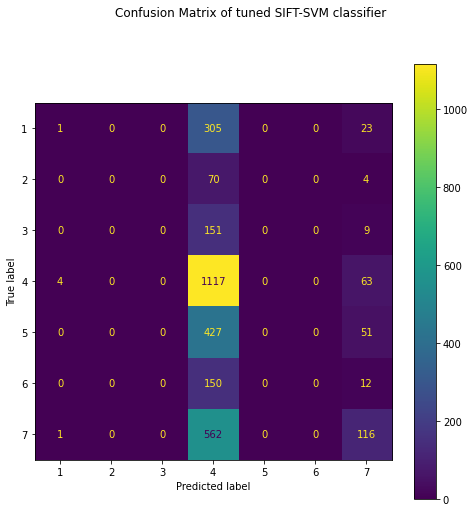

In [80]:
# confusion metrix after tuning the classifier
fig, ax = plt.subplots(figsize=(8,8))
disp = metrics.plot_confusion_matrix(svm_grid_classifier, X_test, y_test, values_format = 'd', ax=ax)
disp.figure_.suptitle("Confusion Matrix of tuned SIFT-SVM classifier")
plt.show()

## Save the SIFT-SVM classifier

the trained classifier model is saved on the drive with the help of joblib library

In [81]:
#save the classifier
from joblib import dump
path = os.path.join('drive', 'My Drive', 'Colab Notebooks/computerVision/Cw/SIFT_SVM' )
dump(svm_classifier, path) 

['drive/My Drive/Colab Notebooks/computerVision/Cw/SIFT_SVM']

# SIFT-MLP

## Training MLP classifier

In [82]:
####### HOG MLP classification ##############
from sklearn.neural_network import MLPClassifier

# MLP, Multi-Layer Perceptron, classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(50,), max_iter=100, alpha=1e-4,
                    solver='sgd', verbose=True, random_state=1,
                    learning_rate_init=.1)

#fit the train set to the classifier
mlp_classifier.fit(X_train, y_train)

Iteration 1, loss = 1.66398339
Iteration 2, loss = 1.64011173
Iteration 3, loss = 1.63782848
Iteration 4, loss = 1.63473234
Iteration 5, loss = 1.62970239
Iteration 6, loss = 1.62507973
Iteration 7, loss = 1.61909167
Iteration 8, loss = 1.61146991
Iteration 9, loss = 1.60323524
Iteration 10, loss = 1.59849191
Iteration 11, loss = 1.59413713
Iteration 12, loss = 1.59116207
Iteration 13, loss = 1.58623668
Iteration 14, loss = 1.58285918
Iteration 15, loss = 1.57875765
Iteration 16, loss = 1.57629395
Iteration 17, loss = 1.57317171
Iteration 18, loss = 1.57039794
Iteration 19, loss = 1.56840431
Iteration 20, loss = 1.56469006
Iteration 21, loss = 1.56279254
Iteration 22, loss = 1.56027900
Iteration 23, loss = 1.55777580
Iteration 24, loss = 1.55611623
Iteration 25, loss = 1.55364682
Iteration 26, loss = 1.55237942
Iteration 27, loss = 1.55182770
Iteration 28, loss = 1.54964584
Iteration 29, loss = 1.54766836
Iteration 30, loss = 1.54715076
Iteration 31, loss = 1.54530484
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(50,), learning_rate='constant',
              learning_rate_init=0.1, max_fun=15000, max_iter=100, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=1, shuffle=True, solver='sgd', tol=0.0001,
              validation_fraction=0.1, verbose=True, warm_start=False)

## Evaluating the trained MLP classifier

In [83]:
# pridict the test set
mlp_predicted= mlp_classifier.predict(X_test)

In [84]:
# printing the score of the MLP classifier
print(f"""Classification report for classifier {mlp_classifier}:\n
      {metrics.classification_report(y_test, mlp_predicted)}""")

Classification report for classifier MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(50,), learning_rate='constant',
              learning_rate_init=0.1, max_fun=15000, max_iter=100, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=1, shuffle=True, solver='sgd', tol=0.0001,
              validation_fraction=0.1, verbose=True, warm_start=False):

                    precision    recall  f1-score   support

           1       0.38      0.14      0.20       329
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00       160
           4       0.46      0.77      0.58      1184
           5       0.29      0.18      0.22       478
           6       0.20      0.01      0.01       162
           7       0.34      0.33      0.33       679

    accuracy     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


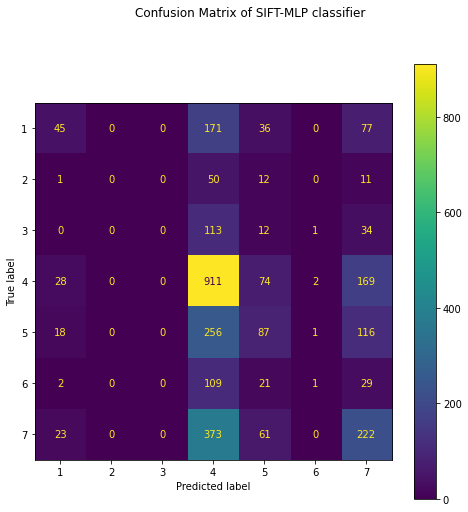

In [85]:
# confusion metrix of SIFT-MLP classifier
fig, ax = plt.subplots(figsize=(8,8))
disp = metrics.plot_confusion_matrix(mlp_classifier, X_test, y_test, values_format = 'd', ax=ax)
disp.figure_.suptitle("Confusion Matrix of SIFT-MLP classifier")
plt.show()

## Improving the MLP classifier

### Hyper-Parameter tuning

In [86]:
# adapted from https://datascience.stackexchange.com/questions/36049/how-to-adjust-the-hyperparameters-of-mlp-classifier-to-get-more-perfect-performa
#parameters
mlp_param_grid = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['adaptive']}
  
#classifier  
mlp_grid_classifier = GridSearchCV(MLPClassifier(max_iter=100), mlp_param_grid, refit = True, verbose = 3)  

# training to find the best parameter
mlp_grid_classifier.fit(X_train, y_train)


Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.5s remaining:    0.0s


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, score=0.389, total=  16.5s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   32.5s remaining:    0.0s


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, score=0.389, total=  16.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, score=0.389, total=  16.4s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, score=0.389, total=  16.3s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, score=0.389, total=  16.4s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, score=0.408, total=  17.9s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, score=0.416, total=  18.2s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, score=0.408, total=  17.7s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, score=0.403, total=  17.8s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, score=0.423, total=  18.1s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, score=0.389, total=  20.2s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, score=0.389, total=  20.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, score=0.390, total=  20.1s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, score=0.389, total=  20.3s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, score=0.389, total=  20.3s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, score=0.409, total=  21.9s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, score=0.422, total=  21.9s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, score=0.411, total=  21.9s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, score=0.408, total=  22.1s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, score=0.418, total=  21.7s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd, score=0.389, total=  10.1s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd, score=0.389, total=  10.3s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd, score=0.389, total=  10.6s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd, score=0.389, total=  10.5s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd, score=0.389, total=  10.5s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam, score=0.408, total=   8.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam, score=0.415, total=  11.4s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam, score=0.413, total=  11.3s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam, score=0.408, total=  10.5s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam, score=0.416, total=  10.7s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, score=0.389, total=  16.6s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, score=0.389, total=  16.2s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, score=0.389, total=  16.4s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, score=0.389, total=  16.2s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, score=0.389, total=  16.2s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, score=0.404, total=  17.5s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, score=0.418, total=  17.5s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, score=0.417, total=  15.5s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, score=0.407, total=  13.2s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, score=0.416, total=  17.4s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, score=0.389, total=  20.2s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, score=0.389, total=  19.9s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, score=0.389, total=  20.1s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, score=0.389, total=  20.1s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, score=0.389, total=  20.1s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, score=0.403, total=  15.5s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, score=0.417, total=  21.6s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, score=0.416, total=  21.5s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, score=0.397, total=  21.6s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, score=0.415, total=  16.9s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd, score=0.389, total=  10.4s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd 
[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd, score=0.389, total=  10.0s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd 
[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd, score=0.389, total=  10.1s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd 
[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd, score=0.389, total=  10.3s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd, score=0.389, total=  10.4s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam 
[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam, score=0.403, total=   9.2s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam 
[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam, score=0.418, total=   9.8s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam 
[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam, score=0.409, total=   8.4s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam 
[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam, score=

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam, score=0.413, total=  11.1s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, score=0.389, total=  12.1s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, score=0.389, total=  10.4s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, score=0.389, total=  11.4s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, score=0.389, total=  10.2s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 
[CV]  activation=relu, alpha=0.0001, hidden_laye

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, score=0.398, total=  13.2s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, score=0.413, total=  13.2s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, score=0.403, total=  13.5s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, score=0.392, total=  13.4s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, score=0.398, total=  13.4s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, score=0.389, total=  12.6s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, score=0.389, total=  13.5s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, score=0.389, total=  13.5s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 
[CV]  activation=relu, alpha=0.0001, hid

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, score=0.381, total=  15.7s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, score=0.404, total=  15.6s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, score=0.401, total=  15.6s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, score=0.384, total=  15.8s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, score=0.389, total=  15.7s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd, score=0.389, total=   7.5s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd, score=0.389, total=   7.7s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd, score=0.389, total=   7.4s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd, score=0.389, total=   7.5s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd, score=0.389, total=   7.6s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam, score=0.411, total=   8.6s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam, score=0.424, total=   8.4s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam, score=0.413, total=   8.5s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam, score=0.417, total=   8.4s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam, score=0.416, total=   8.6s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 
[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, score=0.389, total=  11.6s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 
[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, score=0.389, total=  12.0s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 
[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, score=0.389, total=  11.3s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 
[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50),

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, score=0.406, total=  13.3s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, score=0.421, total=  12.9s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, score=0.416, total=  13.3s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, score=0.410, total=  13.1s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, score=0.417, total=  13.0s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 
[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, score=0.389, total=  13.6s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 
[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, score=0.389, total=  12.8s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 
[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, score=0.389, total=  13.2s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, score=0.389, total=  14.5s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 
[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, score=0.389, total=  13.8s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, score=0.406, total=  15.5s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, score=0.416, total=  15.6s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, score=0.415, total=  15.7s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, score=0.410, total=  15.4s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, score=0.415, total=  15.5s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd, score=0.389, total=   7.8s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd, score=0.389, total=   7.7s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd 
[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd, score=0.389, total=   7.2s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd, score=0.389, total=   7.6s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd, score=0.389, total=   7.8s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam, score=0.408, total=   8.2s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam, score=0.413, total=   8.2s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam, score=0.411, total=   8.4s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam, score=0.407, total=   8.3s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 27.3min finished


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam, score=0.419, total=   8.2s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


GridSearchCV(cv=None, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=100, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_st...
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'activation': ['

In [87]:
# print best parameter after tuning

print(mlp_grid_classifier.best_params_)
print(mlp_grid_classifier.best_estimator_)

{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'solver': 'adam'}
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='adaptive',
              learning_rate_init=0.001, max_fun=15000, max_iter=100,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


### Evaluating the tuned SIFT-MLP

In [88]:
# pridict the test set
mlp_grid_predicted= mlp_grid_classifier.predict(X_test)


In [89]:
# printing the score of the tuned MLP classifier
print(f"""Classification report for tuned SIFT-MLP classifier {mlp_grid_classifier}:\n
      {metrics.classification_report(y_test, mlp_grid_predicted)}""")

Classification report for tuned SIFT-MLP classifier GridSearchCV(cv=None, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=100, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_st...
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


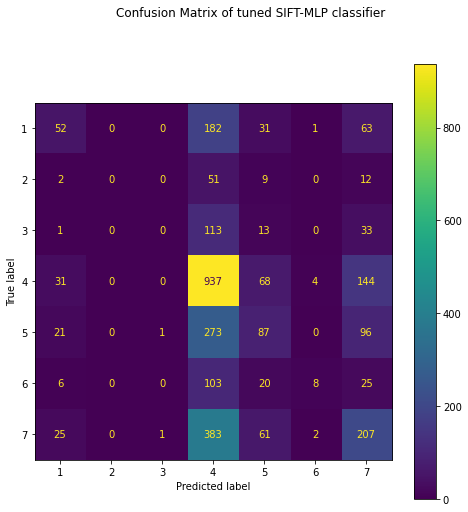

In [90]:
# confusion metrix of HOG-MLP classifier after grid search
fig, ax = plt.subplots(figsize=(8,8))
disp = metrics.plot_confusion_matrix(mlp_grid_classifier, X_test, y_test, values_format = 'd', ax=ax)
disp.figure_.suptitle("Confusion Matrix of tuned SIFT-MLP classifier")
plt.show()

## Save SIFT-MLP

In [91]:
#save the classifier
path = os.path.join('drive', 'My Drive', 'Colab Notebooks/computerVision/Cw/SIFT_MLP' )
dump(mlp_grid_classifier, path) 

['drive/My Drive/Colab Notebooks/computerVision/Cw/SIFT_MLP']

# SIFT-Random Forest Classifier

## Training the Random Forest classifier

In [92]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier()

#Training the classifier with HOG features descriptors
rf_classifier.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

## Evaluating the trained Random Forest classifier

In [93]:
#predicting the test set
rf_predicted = rf_classifier.predict(X_test)


In [94]:
#eevaluating random forest classifier
print(f"""Classification report for classifier {rf_classifier}:
      {metrics.classification_report(y_test, rf_predicted)}\n""")

Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False):
                    precision    recall  f1-score   support

           1       0.40      0.03      0.06       329
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00       160
           4       0.41      0.89      0.57      1184
           5       0.27      0.03      0.05       478
           6       0.00      0.00      0.00       162
           7       0.34      0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


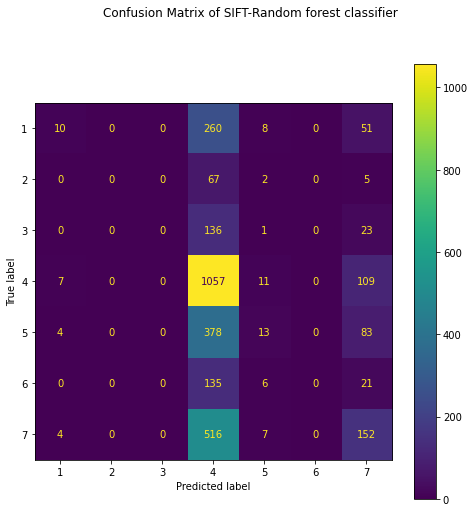

In [95]:
# confusion metrix of random fore classifier
fig, ax = plt.subplots(figsize=(8,8))
disp = metrics.plot_confusion_matrix(rf_classifier, X_test, y_test, values_format = 'd', ax=ax)
disp.figure_.suptitle("Confusion Matrix of SIFT-Random forest classifier")
plt.show()

## Improving the SVM classifier

### Hyper-Parameter tuning

In [96]:
# Hyper parameter tuning for random forest classifier using grid search
rf_grid_params = {
    'n_estimators': [10,50,100, 150, 250],
    'min_samples_split': [2, 4, 6]
}

rf_grid_classifier = GridSearchCV(RandomForestClassifier(), rf_grid_params, cv=5, verbose=5)
rf_grid_classifier.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] min_samples_split=2, n_estimators=10 ............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  min_samples_split=2, n_estimators=10, score=0.365, total=   0.5s
[CV] min_samples_split=2, n_estimators=10 ............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  min_samples_split=2, n_estimators=10, score=0.350, total=   0.5s
[CV] min_samples_split=2, n_estimators=10 ............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s


[CV]  min_samples_split=2, n_estimators=10, score=0.375, total=   0.5s
[CV] min_samples_split=2, n_estimators=10 ............................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.5s remaining:    0.0s


[CV]  min_samples_split=2, n_estimators=10, score=0.355, total=   0.5s
[CV] min_samples_split=2, n_estimators=10 ............................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.0s remaining:    0.0s


[CV]  min_samples_split=2, n_estimators=10, score=0.353, total=   0.5s
[CV] min_samples_split=2, n_estimators=50 ............................
[CV]  min_samples_split=2, n_estimators=50, score=0.389, total=   2.4s
[CV] min_samples_split=2, n_estimators=50 ............................
[CV]  min_samples_split=2, n_estimators=50, score=0.408, total=   2.3s
[CV] min_samples_split=2, n_estimators=50 ............................
[CV]  min_samples_split=2, n_estimators=50, score=0.406, total=   2.7s
[CV] min_samples_split=2, n_estimators=50 ............................
[CV]  min_samples_split=2, n_estimators=50, score=0.395, total=   2.4s
[CV] min_samples_split=2, n_estimators=50 ............................
[CV]  min_samples_split=2, n_estimators=50, score=0.394, total=   2.3s
[CV] min_samples_split=2, n_estimators=100 ...........................
[CV]  min_samples_split=2, n_estimators=100, score=0.406, total=   4.7s
[CV] min_samples_split=2, n_estimators=100 ...........................
[CV] 

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:  6.4min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [97]:
# print best parameter after tuning
print(rf_grid_classifier.best_params_)


{'min_samples_split': 6, 'n_estimators': 150}


### Evaluating the tuned Random Forest Classifier

In [98]:
#predicting of test set
rf_grid_predicted = rf_grid_classifier.predict(X_test)


In [99]:
#printing the score of tuned random forest classifier
print(f"""Classification report for classifier {rf_grid_classifier}:
      {metrics.classification_report(y_test, rf_grid_predicted)}\n""")

Classification report for classifier GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
              

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


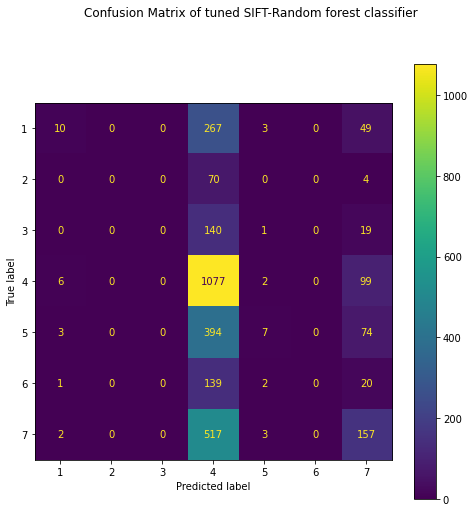

In [100]:
# confusion metrix of  classifier
fig, ax = plt.subplots(figsize=(8,8))
disp = metrics.plot_confusion_matrix(rf_grid_classifier, X_test, y_test, values_format = 'd', ax=ax)
disp.figure_.suptitle("Confusion Matrix of tuned SIFT-Random forest classifier")
plt.show()

## Save SIFT-Random Forest Classifier

In [101]:
#save the classifier
path = os.path.join('drive', 'My Drive', 'Colab Notebooks/computerVision/Cw/SIFT_RFC' )
dump(rf_grid_classifier, path) 

['drive/My Drive/Colab Notebooks/computerVision/Cw/SIFT_RFC']